In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import scipy

In [2]:
sys.path.append('..')
import UNet
sys.path.append('/home/dwu/DeepRecon/ReconNet/python/')
import ReconNet
sys.path.append('/home/dwu/DeepRecon/')
import helper

In [3]:
import argparse
parser = argparse.ArgumentParser(
    description = 'pre-training for noise2noise, this will significantly accelerate convergence')

# paths
parser.add_argument('--checkPoint', dest='checkPoint', type=str, default=None)
parser.add_argument('--sino', dest='sino', type=str, 
                    default='../../train/recon/data/sino/quarter_sino.npy')
parser.add_argument('--ref', dest='ref', type=str, 
                    default='../../train/recon/data/sino/full_gaussian.npy')
parser.add_argument('--resolution', dest='resolution', type=str, 
                    default='../../train/recon/data/sino/resolutions.npy')
parser.add_argument('--paramFile', dest='paramFile', type=str, 
                    default='../../train/recon/data/sino/param.txt')

# simulation
parser.add_argument('--N0', dest='N0', type=float, default=-1)
parser.add_argument('--doseRate', dest='doseRate', type=float, default=0.25)
parser.add_argument('--filter', dest='filter', type=int, default=2, 
                    help='filter for fbp: 0-RL, 2-Hann')

# general network training
parser.add_argument('--device', dest='device', type=int, default=0)
parser.add_argument('--nSlices', dest='nSlices', type=int, default=10)
parser.add_argument('--preLr', dest='preLr', type=float, default=1e-3)
parser.add_argument('--nPatchesPerImg', dest='nPatchesPerImg', type=int, default=4)
parser.add_argument('--outputInterval', dest='outputInterval', type=int, default=50)

# general iteration
parser.add_argument('--nPreTrainingIters', dest='nPreTrainingIters', type=int, default=1000)

# data augmentation
parser.add_argument('--aug', dest='aug', type=int, default=1)
parser.add_argument('--imgNorm', dest='imgNorm', type=float, default=0.019)
parser.add_argument('--imgOffset', dest='imgOffset', type=float, default=-1)

# window
parser.add_argument('--vmin', dest='vmin', type=float, default=0.84)
parser.add_argument('--vmax', dest='vmax', type=float, default=1.24)

_StoreAction(option_strings=['--vmax'], dest='vmax', nargs=None, const=None, default=1.24, type=<class 'float'>, choices=None, help=None, metavar=None)

In [4]:
tf.reset_default_graph()
net = UNet.UNet()
parser = net.AddArgsToArgParser(parser)

In [5]:
if sys.argv[0] != 'pretrain_2d.py':
    from IPython import display
    import matplotlib.pyplot as plt
    %matplotlib inline
    args = parser.parse_args(['--device', '0',
                              '--imgshape', '640', '640', '1',
                              '--nPatchesPerImg', '1',
                              '--beta', '0',
                              '--bn', '0',
                              '--nSlices', '1',
                              '--filter', '2',
                              '--depth', '3',
#                               '--vmin', '-0.15',
#                               '--vmax', '1.15',
                              '--nPreTrainingIters', '10000',
                              '--checkPoint', 
                              '../../train/recon/n2n_2d/pretrain/beta_0_filter_2_quarter_encoder_decoder_depth_3_10000',
                              '--model', 'encoder_decoder'])
else:
    args = parser.parse_args(sys.argv[1:])

    
for k in args.__dict__:
    print (k, args.__dict__[k], sep=': ', flush=True)

checkPoint: ../../train/recon/n2n_2d/pretrain/beta_0_filter_2_quarter_encoder_decoder_depth_3_10000
sino: ../../train/recon/data/sino/quarter_sino.npy
ref: ../../train/recon/data/sino/full_gaussian.npy
resolution: ../../train/recon/data/sino/resolutions.npy
paramFile: ../../train/recon/data/sino/param.txt
N0: -1
doseRate: 0.25
filter: 2
device: 0
nSlices: 1
preLr: 0.001
nPatchesPerImg: 1
outputInterval: 50
nPreTrainingIters: 10000
aug: 1
imgNorm: 0.019
imgOffset: -1
vmin: 0.84
vmax: 1.24
scope: unet2d
imgshape: [640, 640, 1]
nFilters: 32
filterSz: [3, 3, 3]
depth: 3
model: encoder_decoder
bn: 0
beta: 0.0


In [6]:
tf.reset_default_graph()
net = UNet.UNet()
net.FromParser(args)
net.BuildN2NModel()

learningRate = tf.placeholder(tf.float32, None, 'lr')

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learningRate).minimize(net.loss)

reconNet = ReconNet.ReconNet()
reconNet.FromFile(args.paramFile)
reconNet.cSetDevice(args.device)

testingNet = UNet.UNet()
testingNet.FromParser(args)
testingNet.scope = net.scope + 'Test'
testingNet.imgshape = [reconNet.nx, reconNet.ny, 1]
testingNet.BuildN2NModel()

weightCopiers = [tf.assign(r, v) for r,v in zip(tf.trainable_variables(testingNet.scope), 
                                                tf.trainable_variables(net.scope+'/'))]


saver = tf.train.Saver(var_list = tf.trainable_variables(net.scope+'/'))

if not os.path.exists(os.path.dirname(args.checkPoint)):
    os.makedirs(os.path.dirname(args.checkPoint))

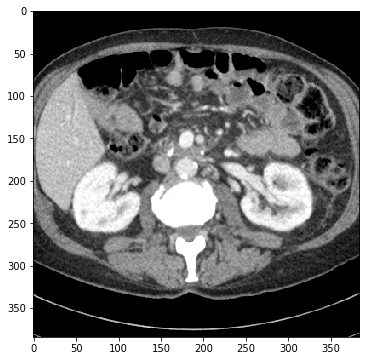

In [7]:
# read phantom
np.random.seed(0)
x = np.load(args.ref)
resolutions = np.load(args.resolution)

inds = np.arange(x.shape[0])
np.random.shuffle(inds)
x = x[inds[:args.nSlices], ...]
resolutions = resolutions[inds[:args.nSlices]]

refs = x / args.imgNorm

plt.figure(figsize=[6,6])
plt.imshow(refs[0, 128:-128, 128:-128, 0].T, 'gray', vmin=args.vmin, vmax=args.vmax)

In [8]:
# read projection
prjs = np.load(args.sino)
prjs = prjs[inds[:args.nSlices], ...] / args.imgNorm

np.random.seed(0)
if args.N0 > 0:
    prjs = prjs + np.sqrt((1 - args.doseRate) / args.doseRate * np.exp(prjs * args.imgNorm) / args.N0) \
    * np.random.normal(size = prjs.shape) / args.imgNorm

In [9]:
# mask for network training
masks = helper.GetMasks2D(reconNet, resolutions)

In [10]:
# projection split
np.random.seed(0)
imgs1 = []
imgs2 = []

for i in range(prjs.shape[0]):
    if i % 10 == 0:
        print (i, end=', ')
    
    inds = np.arange(0, prjs.shape[2], 2).astype(int)
    shift = np.random.randint(0, 2, inds.shape)
    set1 = inds + shift
    set2 = inds + (1 - shift)
    
    reconNet.dx = resolutions[i]
    reconNet.dy = resolutions[i]
    
    fp = prjs[[i],...]
    
    fsino = reconNet.cFilter3d(np.copy(fp[[0], ...], 'C'), args.filter)
    imgs1.append(reconNet.cDDFanBackprojection3d(np.copy(fsino[:, :, set1, :], 'C'), np.array(reconNet.angles)[set1], 
                                                 type_projector=1))
    imgs2.append(reconNet.cDDFanBackprojection3d(np.copy(fsino[:, :, set2, :], 'C'), np.array(reconNet.angles)[set2], 
                                                 type_projector=1))
imgs1 = np.concatenate(imgs1, 0) * 2
imgs2 = np.concatenate(imgs2, 0) * 2

0, 

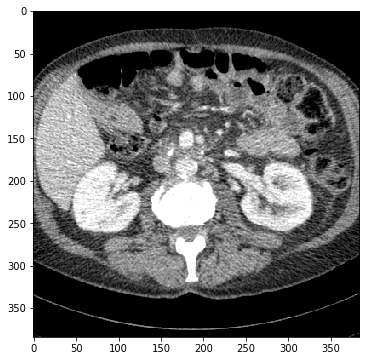

In [11]:
plt.figure(figsize=[6,6])
plt.imshow(((imgs1+imgs2)/2)[0, 128:-128, 128:-128, 0].T, 'gray', vmin=args.vmin, vmax=args.vmax)

In [12]:
sess = tf.Session(config = tf.ConfigProto(gpu_options = tf.GPUOptions(visible_device_list='%s'%args.device, 
                                                                      allow_growth=True)))
sess.run(tf.global_variables_initializer())

In [13]:
def Prediction(sess, imgs1, imgs2, refs, net, args, masks = None):
    if masks is None:
        masks = np.ones_like(imgs1)
    
    losses = []
    lossesN2n = []
    recons = []
    for iSlice in range(imgs1.shape[0]):
        loss, lossN2n, recon = \
        sess.run([net.loss, net.lossN2n, net.recon], 
                 {net.x1: imgs1[[iSlice], ...] + args.imgOffset, 
                  net.x2: imgs2[[iSlice], ...] + args.imgOffset, 
                  net.ref: refs[[iSlice], ...] + args.imgOffset,
                  net.mask: masks[[iSlice], ...],
                  net.training: True})
    
        recon -= args.imgOffset
        
        losses.append(loss)
        lossesN2n.append(lossN2n)
        recons.append(recon)
    
    return np.mean(losses), np.mean(lossN2n), np.concatenate(recons)

In [14]:
def ExtractPatches(imgList, patchSize, nPatchesPerImg):
    imgshape = imgList[0].shape
    
    ixs = np.random.randint(0, imgshape[1] - patchSize[0] + 1, imgshape[0] * nPatchesPerImg)
    iys = np.random.randint(0, imgshape[2] - patchSize[1] + 1, imgshape[0] * nPatchesPerImg)
    
    patchList = []
    for img in imgList:
        patches = np.zeros([img.shape[0] * nPatchesPerImg, patchSize[0], patchSize[1], 1], np.float32)
        for i, (ix, iy) in enumerate(zip(ixs, iys)):
            patches[i, ..., 0] = img[int(i / nPatchesPerImg), ix:ix+patchSize[0], iy:iy+patchSize[1], 0]
        patchList.append(patches)
    
    return patchList

rmse = 0.0274154


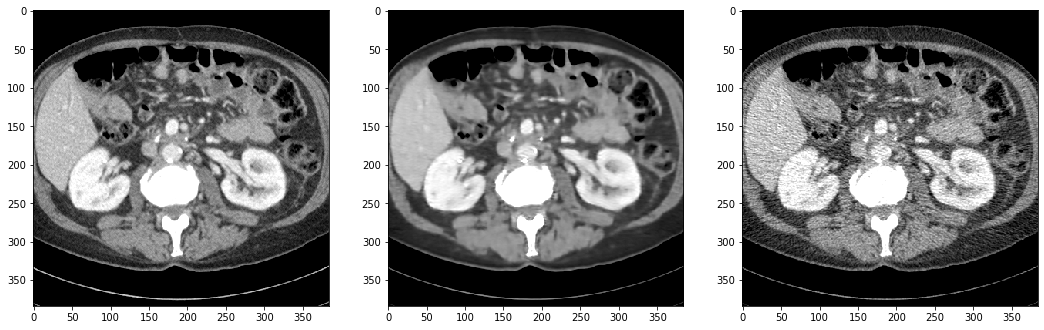

4604 0.0015785596
4609 0.0015737521
4614 0.0015741637
4619 0.0015717212
4624 0.0015676637
4629 0.001574684
4634 0.0015803678
4639 0.0015731407
4644 0.0015814324
4649 0.0015812292
4654 0.00157264
4659 0.0015816882
4664 0.0015735755
4669 0.0015752775
4674 0.0015772867
4679 0.0015733878
4684 0.0015747275
4689 0.0015657474


In [ ]:
# pre-training
np.random.seed(0)

for iIter in range(args.nPreTrainingIters):
    patches = ExtractPatches([imgs1, imgs2, masks], net.imgshape, args.nPatchesPerImg)

    if args.aug:
        aug = np.random.randint(4)
        for i in range(len(patches)):
            patches[i] = helper.Augmentation(patches[i], aug)

    _, loss = sess.run([train_step, net.loss], 
                       {net.x1: patches[0] + args.imgOffset, 
                        net.x2: patches[1] + args.imgOffset, 
                        net.ref: (patches[0] + patches[1]) / 2 + args.imgOffset, 
                        net.mask: patches[2], 
                        net.betaInput: args.beta,
                        net.training: True, 
                        learningRate: args.preLr})

    if (iIter + 1) % 5 == 0:
        print (iIter, loss)

    if (iIter + 1) % 200 == 0:
        _ = sess.run(weightCopiers)
        _, _, recon = Prediction(sess, imgs1, imgs2, refs, testingNet, args, masks)

        rmse = np.sqrt(np.sum((recon - refs)**2 * masks) / np.sum(masks))
        iSlice = np.random.randint(imgs1.shape[0])

        display.clear_output()
        print ('rmse = %g'%rmse)
        plt.figure(figsize=[18,6])
        plt.subplot(131); plt.imshow(refs[iSlice, 128:-128, 128:-128, 0].T, 'gray', vmin=args.vmin, vmax=args.vmax)
        plt.subplot(132); plt.imshow(recon[iSlice, 128:-128, 128:-128, 0].T, 'gray', vmin=args.vmin, vmax=args.vmax)
        plt.subplot(133); plt.imshow(((imgs1+imgs2)/2)[iSlice, 128:-128, 128:-128, 0].T, 'gray', vmin=args.vmin, vmax=args.vmax)
        plt.show()

saver.save(sess, args.checkPoint)